Written by Fatima, update to cnn.ipynb

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import apply_affine_transform
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau
import keras_tuner as kt
from keras_tuner.tuners import Hyperband

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight


from PIL import Image
import matplotlib.pyplot as plt

from collections import Counter


# Load Dataset

In [2]:
CSV_FILE_NAME = './data/my_file_200.csv'
# CSV_FILE_NAME = './data/my_file_400.csv'
arr = pd.read_csv(CSV_FILE_NAME, header=None)

In [3]:
X, y_class, y_reg = arr.iloc[:, :-5].values, arr.iloc[:, -5:-4].values, arr.iloc[:, -4:].values
X = X.reshape(-1, 200, 200, 1)
# X = X.reshape(-1, 400, 400, 1)


# one hot encoding
y_class = tf.keras.utils.to_categorical(y_class, num_classes=17)

# dataset split
X_train, X_test, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.2, random_state=42, stratify=y_class)


# if no data augmentation
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train_class.argmax(axis=1)),
                                                  y=y_train_class.argmax(axis=1))

class_weights_dict = dict(enumerate(class_weights))


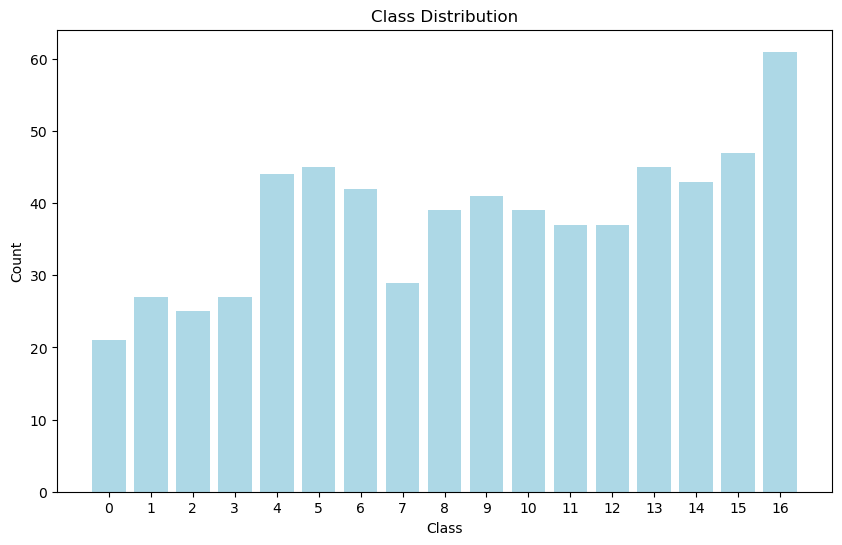

In [27]:
y_counts = Counter(y_class.argmax(axis=1).flatten())
class_distribution = pd.DataFrame({'Class': list(y_counts.keys()), 'Counts': list(y_counts.values())})
class_distribution = class_distribution.sort_values(by='Class').reset_index(drop=True)

plt.figure(figsize=(10, 6))
plt.bar(class_distribution['Class'], class_distribution['Counts'], color='lightblue')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(class_distribution['Class'])
plt.show()


In [4]:
train_counts = Counter(y_train_class.argmax(axis=1).flatten())
test_counts = Counter(y_test_class.argmax(axis=1).flatten())
class_distribution = pd.DataFrame({'Class': list(train_counts.keys()), 'Train': list(train_counts.values()), 'Test': list(test_counts.values())})
class_distribution = class_distribution.sort_values(by='Class').reset_index(drop=True)

print(class_distribution)

    Class  Train  Test
0       0     17     7
1       1     22    10
2       2     20    12
3       3     22     4
4       4     35     9
5       5     36     9
6       6     33     8
7       7     23     9
8       8     31     9
9       9     33     9
10     10     31     7
11     11     30     8
12     12     30     5
13     13     36     6
14     14     34     8
15     15     37     5
16     16     49     5


# Data Augmentation

In [ ]:
# def apply_augmentation(images):
#     augmented_images = []
#     for image in images:
#         augmented_image = image.copy()
                
#         max_shift, max_shear, max_rotate = 0.1 * 200, 45, 45

#         # shear, zoom, shift, rotate
#         shear_angle = np.random.uniform(-max_shear, max_shear)
#         zoom_factor = np.random.uniform(1.1, 1.6) # only zooms out
#         width_shift = np.random.uniform(-max_shift, max_shift)
#         height_shift = np.random.uniform(-max_shift, max_shift)
#         rotation_angle = np.random.uniform(-max_rotate, max_rotate)

#         augmented_image = apply_affine_transform(
#             augmented_image, 
#             shear=shear_angle, 
#             zx=zoom_factor, 
#             zy=zoom_factor,
#             tx=width_shift, 
#             ty=height_shift,
#             theta=rotation_angle,
#             row_axis=0, 
#             col_axis=1, 
#             channel_axis=2,
#             fill_mode='constant',
#             cval=1
#             )

#         # flip
#         if np.random.rand() < 0.5:
#             augmented_image = np.fliplr(augmented_image)
#         if np.random.rand() < 0.5:
#             augmented_image = np.flipud(augmented_image)

#         # brightness
#         brightness_factor = np.random.uniform(0.7, 1.3)
#         augmented_image *= brightness_factor

#         # make sure valeus are between 0 and 1
#         augmented_image = np.clip(augmented_image, 0.0, 1.0)
        
#         augmented_images.append(augmented_image)

#     return augmented_images


In [ ]:
# # add augmented data to each class until they each have 100 samples

# y_train_integers = np.argmax(y_train_class, axis=1)
# max_samples = 100

# X_augmented, y_augmented = [], []

# for label in np.unique(y_train_integers):
#     curr_samples = sum(y_train_integers == label)

#     if curr_samples < max_samples:
#         num_augmented = max_samples - curr_samples

#         samples = X_train[y_train_integers == label]
#         indices = np.random.choice(len(samples), size=num_augmented, replace=True)
#         samples = samples[indices]

#         augmented_samples = apply_augmentation(samples)

#         X_augmented.extend(augmented_samples)

#         one_hot = np.zeros((1, 17))
#         one_hot[0, label] = 1
#         y_augmented.extend([one_hot] * num_augmented)


# X_augmented = np.array(X_augmented)
# y_augmented = np.array(y_augmented)

# X_balanced = np.concatenate((X_train, X_augmented))
# y_balanced = np.concatenate((y_train_class, y_augmented.reshape(-1, 17)))


# # shuffle data
# from random import shuffle

# idx = [i for i in range(X_balanced.shape[0])]
# shuffle(idx)
# X_train_balanced = X_balanced[idx, :, :, :]
# y_train_balanced = y_balanced[idx]

In [ ]:
# print ("number of training examples = " + str(X_train_balanced.shape[0]))
# print ("number of val examples = " + str(X_val.shape[0]))
# print ("number of test examples = " + str(X_test.shape[0]))
# print ("X_train shape: " + str(X_train_balanced.shape))
# print ("Y_train shape: " + str(y_train_balanced.shape))
# print ("X_val shape: " + str(X_val.shape))
# print ("Y_val shape: " + str(y_val_class.shape))
# print ("X_test shape: " + str(X_test.shape))
# print ("Y_test shape: " + str(y_test_class.shape))

In [ ]:
# # display image
# index = 10
# print("label: ", y_train_balanced[index])
# img_array = X_train_balanced[index].reshape(200, 200)
# image = Image.fromarray((img_array * 255))

# plt.imshow(image, cmap='gray')
# plt.show()

# Model

In [ ]:
model = models.Sequential([
    layers.Input(shape=(200, 200, 1)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(17, activation='softmax'),
])

# f1_metric = tf.metrics.F1Score(average='macro')
f1_metric = tf.metrics.F1Score(average='weighted') # if no data augmentation

model.compile(optimizer=Adam(learning_rate=0.001),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy', f1_metric])


model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 198, 198, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 147456)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 147456)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     9,437,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 17)             │         1,105 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,457,169 (36.08 MB)

 Trainable params: 9,457,169 (36.08 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train_class, epochs=50, validation_data=(X_test, y_test_class), class_weight=class_weights_dict) # if no data augmentation

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 702ms/step - accuracy: 0.0763 - f1_score: 0.0609 - loss: 3.5289 - val_accuracy: 0.0615 - val_f1_score: 0.0152 - val_loss: 2.8343
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 454ms/step - accuracy: 0.0961 - f1_score: 0.0593 - loss: 2.8355 - val_accuracy: 0.0538 - val_f1_score: 0.0373 - val_loss: 2.8253
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 416ms/step - accuracy: 0.1938 - f1_score: 0.1766 - loss: 2.7113 - val_accuracy: 0.0923 - val_f1_score: 0.0707 - val_loss: 2.7909
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 392ms/step - accuracy: 0.2967 - f1_score: 0.2736 - loss: 2.3311 - val_accuracy: 0.1231 - val_f1_score: 0.1032 - val_loss: 2.8019
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 380ms/step - accuracy: 0.5387 - f1_score: 0.5298 - loss: 1.5496 - val_accuracy: 0.1538 - val_f1_score: 0.1449 - val_loss: 2.8264
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 391ms/step - accuracy: 0.8075 - f1_score: 0.8094 - loss: 0.8004 - val_accuracy: 0.1538 - val_f1_score: 0.14

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

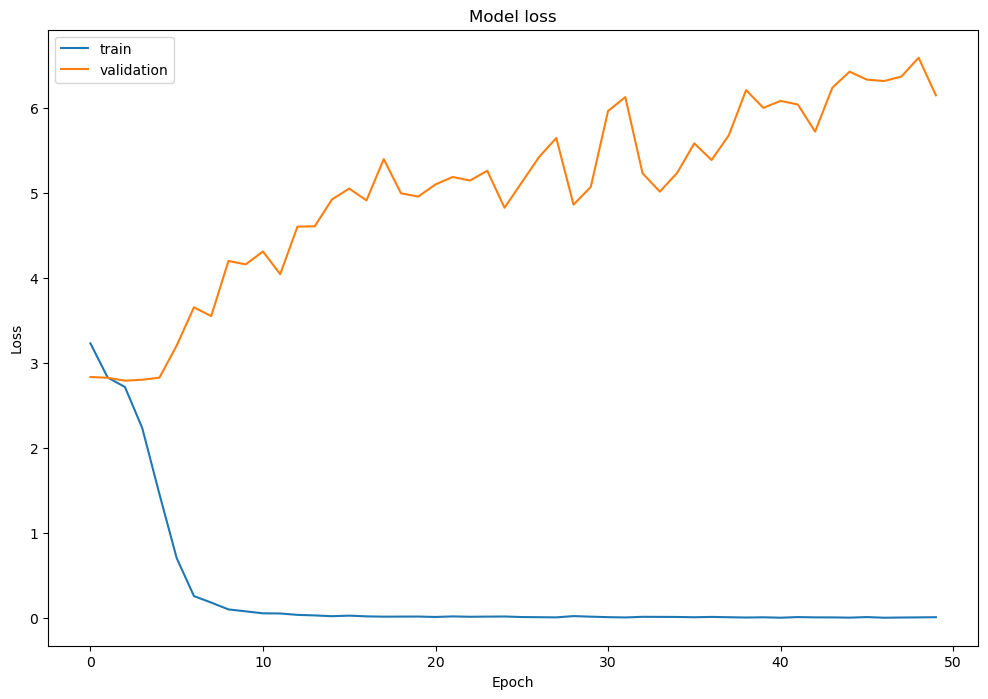

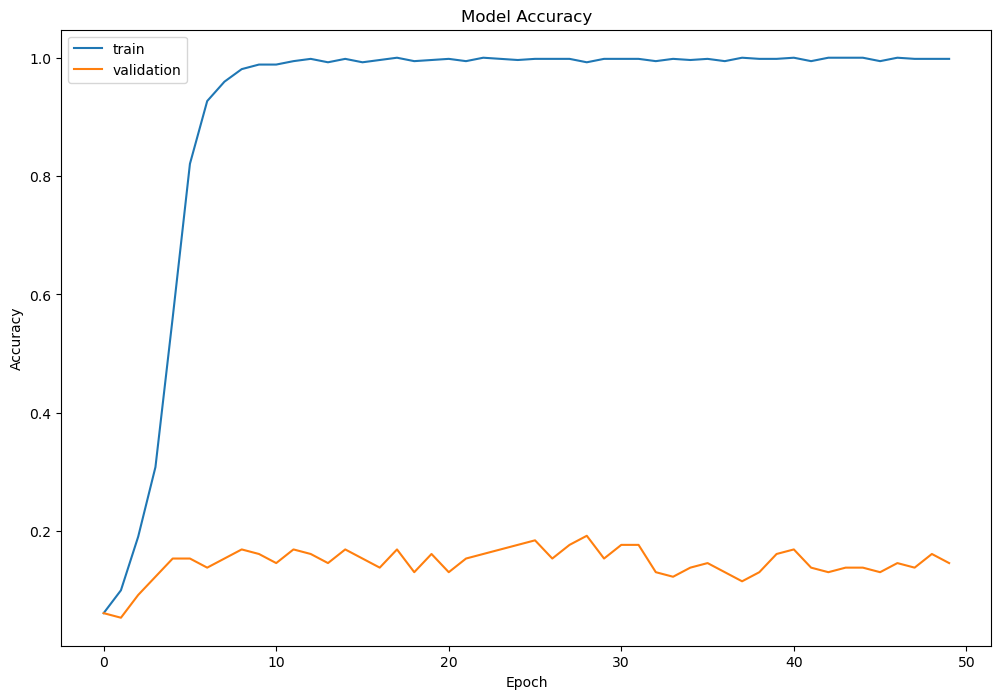

In [ ]:
# Convert model history dictionary to DataFrame
df_loss_acc = pd.DataFrame(model.history.history)

# Select loss columns and rename
df_loss = df_loss_acc[['loss', 'val_loss']].copy()
df_loss.rename(columns={'loss': 'train', 'val_loss': 'validation'}, inplace=True)

# Select accuracy columns and rename
df_acc = df_loss_acc[['accuracy', 'val_accuracy']].copy()
df_acc.rename(columns={'accuracy': 'train', 'val_accuracy': 'validation'}, inplace=True)

# Plot model loss
df_loss.plot(title='Model loss', figsize=(12, 8)).set(xlabel='Epoch', ylabel='Loss')

# Plot model accuracy
df_acc.plot(title='Model Accuracy', figsize=(12, 8)).set(xlabel='Epoch', ylabel='Accuracy')


In [ ]:
test_loss, test_accuracy, test_f1 = model.evaluate(X_test, y_test_class)
print("test_loss:", test_loss)
print("test_f1:", test_f1)
print("test_accuracy:", test_accuracy)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.1672 - f1_score: 0.1531 - loss: 6.1189
test_loss: 6.147792816162109
test_f1: 0.13952738046646118
test_accuracy: 0.14615385234355927


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step


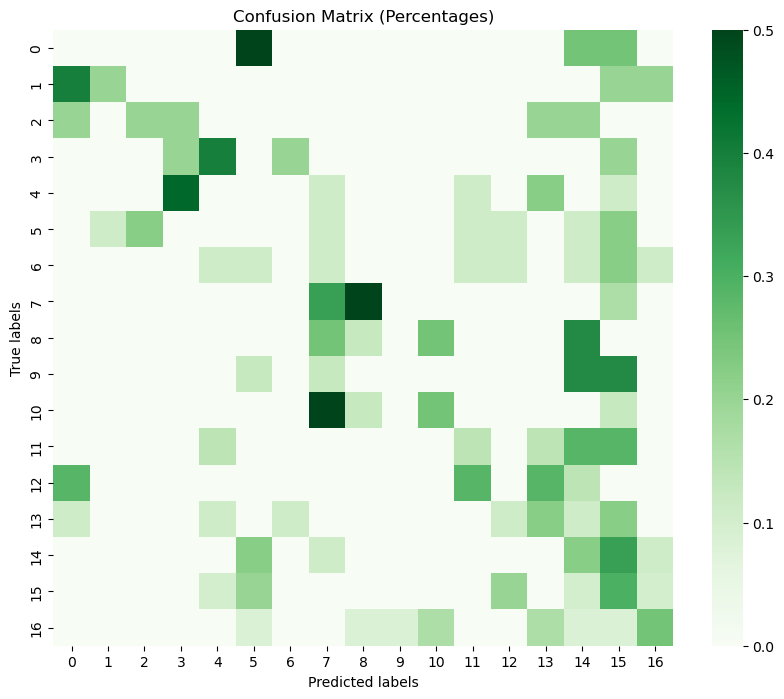

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

test_predictions = model.predict(X_test)

y_true = y_test_class.argmax(axis=1).flatten()
y_pred = test_predictions.argmax(axis=1).flatten()

cm = confusion_matrix(y_true, y_pred)

cm_percent = np.zeros_like(cm, dtype=float)
for i in range(len(cm)):
    cm_percent[i, :] = cm[i, :] / np.sum(cm[i, :])

plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, fmt=".2%", cmap="Greens", cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (Percentages)')
plt.show()


# HyperParameter Tuning

In [5]:
def build_model(hp):
    inputs = layers.Input(shape=(200, 200, 1))
    x = inputs
    
    for i in range(hp.Int('num_layers', 1, 3, default=1)):
        x = layers.Conv2D(
            filters=hp.Int('conv_filter_' + str(i), min_value=32, max_value=128, step=16, default=32),
            kernel_size=hp.Choice('conv_kernel_' + str(i), values=[3, 5]),
            activation='relu'
        )(x)

        x = layers.MaxPooling2D((2,2))(x)

    x = layers.Flatten()(x)

    if hp.Boolean("dropout_1"):
        x = layers.Dropout(rate=hp.Float('dropout_rate_1', min_value=0.1, max_value=0.5, step=0.1))(x)
        x = layers.Dense(
            units=hp.Int('dense_units_1', min_value=32, max_value=128, step=16, default=32),
        )(x)

    x = layers.Dropout(rate=hp.Float('dropout_rate_2', min_value=0.1, max_value=0.5, step=0.1))(x)

    outputs = layers.Dense(17, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)

    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    
    return model


In [ ]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    hyperband_iterations=3,
    directory='hyperband',
    project_name='apriltags'
)

tuner.search_space_summary()

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


In [ ]:
# hyperparameter search
tuner.search(X_train, y_train_class, epochs=20, validation_data=(X_test, y_test_class), class_weight=class_weights_dict, callbacks=[stop_early])

In [9]:
best_hps = tuner.get_best_hyperparameters(num_trials=3) # top three networks

# print best hyperparams
best_hps = tuner.get_best_hyperparameters(num_trials=3) # top three networks
best_hp_config = best_hps[0].get_config()
for key, value in best_hp_config.items():
    print(f"{key}: {value}")

# train using best params
best_model = tuner.hypermodel.build(best_hps[0])
best_model.summary()

best_model.fit(X_train, y_train_class, epochs=20, validation_data=(X_test, y_test_class), class_weight=class_weights_dict)
test_loss, test_accuracy = best_model.evaluate(X_test, y_test_class)

space: [{'class_name': 'Int', 'config': {'name': 'num_layers', 'default': 1, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}}, {'class_name': 'Int', 'config': {'name': 'conv_filter_0', 'default': 32, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': 'linear'}}, {'class_name': 'Choice', 'config': {'name': 'conv_kernel_0', 'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}}, {'class_name': 'Boolean', 'config': {'name': 'dropout_1', 'default': False, 'conditions': []}}, {'class_name': 'Float', 'config': {'name': 'dropout_rate_2', 'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}}, {'class_name': 'Float', 'config': {'name': 'lr', 'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}}, {'class_name': 'Int', 'config': {'name': 'conv_filter_1', 'default': 32, 'conditions': [], 'min_value': 32, 'max_value': 

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 200, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 198, 198, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 97, 97, 48)     │        13,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 110592)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 110592)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 17)             │     1,880,081 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,894,273 (7.23 MB)

 Trainable params: 1,894,273 (7.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 363ms/step - accuracy: 0.0452 - loss: 2.9442 - val_accuracy: 0.0462 - val_loss: 2.7929
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 338ms/step - accuracy: 0.1000 - loss: 2.7777 - val_accuracy: 0.1308 - val_loss: 2.7619
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 323ms/step - accuracy: 0.2996 - loss: 2.6344 - val_accuracy: 0.1385 - val_loss: 2.7073
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 323ms/step - accuracy: 0.4205 - loss: 2.3530 - val_accuracy: 0.1615 - val_loss: 2.6868
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 283ms/step - accuracy: 0.4428 - loss: 2.0953 - val_accuracy: 0.1692 - val_loss: 2.7673
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 288ms/step - accuracy: 0.4415 - loss: 1.9003 - val_accuracy: 0.2000 - val_loss: 2.5711
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 329ms/step - accuracy: 0.6814 - loss: 1.5470 - val_accuracy: 0.2000 - val_loss: 2.6852
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 388ms/step - accuracy: 0.5897 - loss: 1.3688 - val_accuracy: 